<a href="https://colab.research.google.com/github/LuciaManzanoUOC/MTP-UOC/blob/main/GeneralModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Model for detection of skin cancer

Student: Manzano Gómez, Lucía Reyes

Supervisor: Rebrij, Romina Astrid

Date last modification: April 9th, 2022

## CNN Transfer Learning

In this notebook we will develop a Convolutional Neural Network (CNN) to detect skin cancer on images of moles. 

We use a dataset of 1,000 images of benign moles and 1,000 images of malignant melanomas obtained in The International Skin Imaging Collaboration website [`ISIC archive`](https://www.isic-archive.com/). It has been divided between three datasets:

*   Train (70%)
*   Validation (15%)
*   Test (15%)




In [ ]:
# Import of libraries and use of GPUs to accelerate the training of the model.
%tensorflow_version 2.x
import tensorflow as tf
# Check if the GPUs are active
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

# Rest of libraries needed.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from posixpath import join
import os
from keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping
from sklearn import metrics

Found GPU at: /device:GPU:0


In [ ]:
# Mount our Google Drive where the database of images is stored.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Once we are connected to Google Drive, unzip the database to obtain the
# images. These have already been divided among train (70%), test (15%) and 
# validation (15%).
!unzip drive/MyDrive/TFM/Database/Database.zip

Archive:  drive/MyDrive/TFM/Database/Database.zip
   creating: Database/
  inflating: Database/.DS_Store      
  inflating: __MACOSX/Database/._.DS_Store  
   creating: Database/test/
   creating: Database/train/
   creating: Database/validation/
  inflating: Database/test/.DS_Store  
  inflating: __MACOSX/Database/test/._.DS_Store  
   creating: Database/test/Malignant/
   creating: Database/test/Benign/
  inflating: Database/train/.DS_Store  
  inflating: __MACOSX/Database/train/._.DS_Store  
   creating: Database/train/Malignant/
   creating: Database/train/Benign/
  inflating: Database/validation/.DS_Store  
  inflating: __MACOSX/Database/validation/._.DS_Store  
   creating: Database/validation/Malignant/
   creating: Database/validation/Benign/
  inflating: Database/test/Malignant/ISIC_0030521.jpeg  
  inflating: Database/test/Malignant/ISIC_0030171.jpeg  
  inflating: Database/test/Malignant/ISIC_0030034.jpeg  
  inflating: Database/test/Malignant/ISIC_0029995.jpeg  
  inflating

In [ ]:
# Set the number of images in each dataset.
n_benign = 1000
n_malignant = 1000
n_total = n_benign + n_malignant

# Define the percentage of data in each dataset.
n_train = n_total * 70 / 100
n_val = n_total * 15 / 100
n_test = n_total * 15 / 100

# Display information.
print("The number of images in the train dataset is: ", n_train)
print("The number of images in the validation dataset is: ", n_val)
print("The number of images in the test dataset is: ", n_test)

The number of images in the train dataset is:  1400.0
The number of images in the validation dataset is:  300.0
The number of images in the test dataset is:  300.0


In [ ]:
# We start preparing the data before working on the model.
# Definition of batch size.
BATCH_SIZE = 16
# Definition of images size.
IMG_SIZE = (224, 224)

# Build the train dataset.
train_dataset = image_dataset_from_directory("Database/train",
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1400 files belonging to 2 classes.


In [ ]:
# Build the test dataset.
test_dataset = image_dataset_from_directory("Database/test",
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 300 files belonging to 2 classes.


In [ ]:
# Build the validation dataset.
val_dataset = image_dataset_from_directory("Database/validation",
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 300 files belonging to 2 classes.


Examples of benign moles:



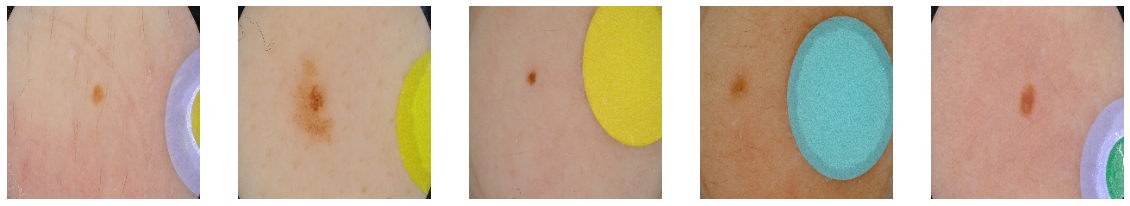

In [ ]:
# Show the first five images of benign moles.
class_names = train_dataset.class_names

plt.figure(figsize=(20, 20))
for images, labels in train_dataset.take(1):
  i = 0
  j = 0
  print("Examples of benign moles:\n")
  while i < 5:
    if(class_names[labels[j]] == "Benign"): 
      ax = plt.subplot(1, 5, i + 1)
      plt.imshow(images[j].numpy().astype("uint8"))
      plt.axis("off")
      i += 1
    j += 1

Examples of malignant melanomas:



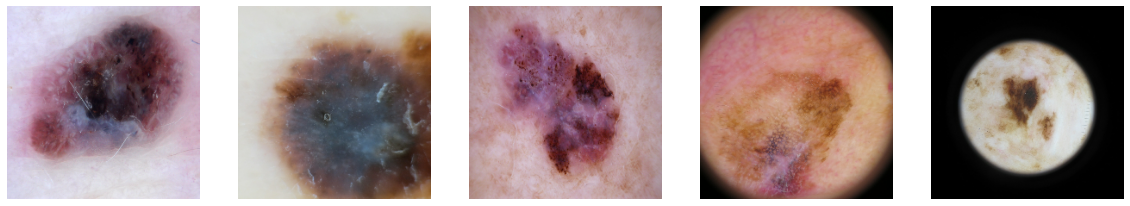

In [ ]:
# And the first five images of malignant melanomas.
plt.figure(figsize=(20, 20))
for images, labels in train_dataset.take(1):
  i = 0
  j = 0
  print("Examples of malignant melanomas:\n")
  while i < 5:
    if(class_names[labels[j]] == "Malignant"): 
      ax = plt.subplot(1, 5, i + 1)
      plt.imshow(images[j].numpy().astype("uint8"))
      plt.axis("off")
      i += 1
    j += 1

In [ ]:
# Creation of the general model.
# Resize the images to have a new third dimension for the Convoutional Neuronal
# Network (CNN). The image shape then is (224, 224, 3)
IMG_SHAPE = IMG_SIZE + (3,)

# Create a first model based on the ResNet50 architecture with no precalculated
# weights
model_ResNet50 = tf.keras.applications.ResNet50(input_shape = IMG_SHAPE,
                                               include_top = False,
                                               pooling = 'avg',
                                               weights = None)

# Visualize the model created
print(model_ResNet50.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# Preparation of the data for the model.
preprocess_input = tf.keras.applications.resnet.preprocess_input
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model_ResNet50(image_batch)
model_ResNet50.trainable = True

# The last layer only have one neuron as only two possible values are needed.
# Depending on the value obtained, the prediction is:
# If the value is a negative number, then the result is Benign .
# If the value is a positive number, then the result is Malignant. 
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)

(16, 1)


In [ ]:
# 
inputs = tf.keras.Input(shape = (224, 224, 3))
x = preprocess_input(inputs)
x = model_ResNet50(x, training = False)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                             

In [ ]:
# Compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

# Usamos la técnica de Early Stopping para evitar el sobreentrenamiento
callbacks = EarlyStopping(monitor = 'val_loss', patience = 3)

# Train the model
history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = val_dataset,
                    callbacks = callbacks)

Epoch 1/10
88/88 [==============================] - 78s 721ms/step - loss: 0.5671 - accuracy: 0.8179 - val_loss: 0.1056 - val_accuracy: 0.9600
Epoch 2/10
88/88 [==============================] - 59s 626ms/step - loss: 0.1592 - accuracy: 0.9464 - val_loss: 0.0739 - val_accuracy: 0.9667
Epoch 3/10
88/88 [==============================] - 58s 617ms/step - loss: 0.1120 - accuracy: 0.9643 - val_loss: 0.0714 - val_accuracy: 0.9633
Epoch 4/10
88/88 [==============================] - 58s 613ms/step - loss: 0.0849 - accuracy: 0.9671 - val_loss: 0.0298 - val_accuracy: 0.9900
Epoch 5/10
88/88 [==============================] - 59s 625ms/step - loss: 0.0531 - accuracy: 0.9807 - val_loss: 0.0754 - val_accuracy: 0.9700
Epoch 6/10
88/88 [==============================] - 58s 615ms/step - loss: 0.0576 - accuracy: 0.9807 - val_loss: 0.0329 - val_accuracy: 0.9900
Epoch 7/10
88/88 [==============================] - 58s 614ms/step - loss: 0.0577 - accuracy: 0.9829 - val_loss: 0.0713 - val_accuracy: 0.9733

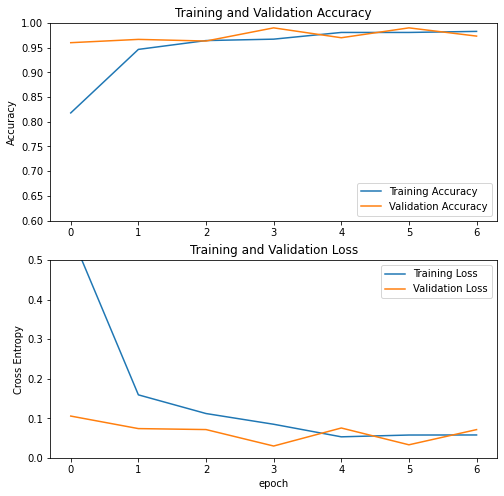

In [ ]:
# Plot the results for the train and validation dataset:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc ='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.6, 1.0])
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc ='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 0.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Save the model
model.save('general_model.h5')
# Load the model
model = load_model('general_model.h5')

In [ ]:
# Evaluate the model using the Test dataset.
loss_test, acc_test = model.evaluate(test_dataset, verbose = 1)
print("Accuracy of the model for Test dataset: {:5.2f}%".format(100 * acc_test))
print("Loss of the model for Test dataset: {:5.2f}%".format(100 * loss_test))

19/19 [==============================] - 11s 284ms/step - loss: 0.0511 - accuracy: 0.9800
Accuracy of the model for Test dataset: 98.00%
Loss of the model for Test dataset:  5.11%


Examples of predictions of the Test dataset:



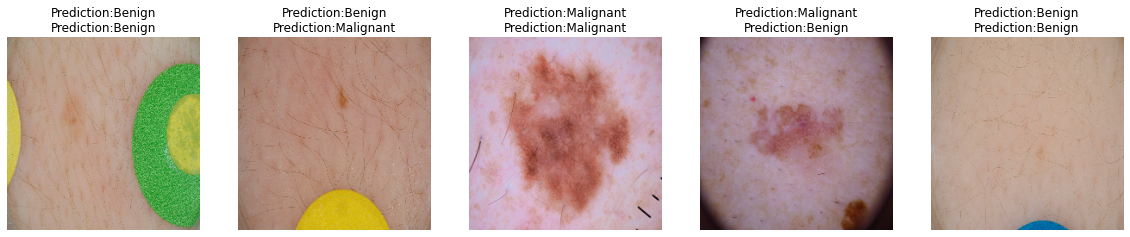

In [ ]:
# Obtain the predictions of the Test.
predictions = model.predict(test_dataset)
predictions_class = []
predictions_binary = []
for i in predictions:
  if i < 0:
    predictions_class.append('Benign')
    predictions_binary.append(0)
  else:
    predictions_class.append('Malignant')
    predictions_binary.append(1)

class_test = test_dataset.class_names

# Display some images of moles from the Test dataset, their diagnosis and the 
# prediction obtained.
plt.figure(figsize=(20, 20))
for images, labels in test_dataset.take(1):
  i = 0
  print("Examples of predictions of the Test dataset:\n")
  while i < 5:
    ax = plt.subplot(1, 5, i + 1)
    real_value = 'Prediction:' + class_test[labels[i]] + '\n'
    prediction_value = 'Prediction:' + predictions_class[i]
    title = real_value + prediction_value
    plt.title(title)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    i += 1

In [ ]:
# Calculate the error of classification as 1 - accuracy of Test dataset
print('The classification error is:', round(1 - acc_test, 2))

The classification error is: 0.02
